<a href="https://colab.research.google.com/github/Zardian18/Celeb-Faces-Variational-Autoencoder/blob/master/celeb_EBM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!wget https://raw.githubusercontent.com/Zardian18/helper-functions-colab/master/helper.py

--2024-01-24 09:08:28--  https://raw.githubusercontent.com/Zardian18/helper-functions-colab/master/helper.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 17171 (17K) [text/plain]
Saving to: ‘helper.py’

helper.py           100%[===================>]  16.77K  --.-KB/s    in 0s      

2024-01-24 09:08:28 (100 MB/s) - ‘helper.py’ saved [17171/17171]



In [2]:
!pip install kaggle

In [3]:
from google.colab import drive
drive.mount("/content/drive")

! mkdir ~/.kaggle
!cp /content/drive/MyDrive/kaggle/kaggle.json ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json

Mounted at /content/drive


In [4]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, callbacks, utils, metrics, losses, optimizers, activations
from helper import sample_batch, display
import pandas as pd
import numpy as np
import tensorflow.keras.backend as K
import matplotlib.pyplot as plt
import tensorflow_probability as tfp

In [5]:
! kaggle datasets download -d jessicali9530/celeba-dataset

100% 1.33G/1.33G [01:09<00:00, 21.1MB/s]
100% 1.33G/1.33G [01:09<00:00, 20.6MB/s]


In [ ]:
!unzip celeba-dataset.zip

In [13]:
train_data = utils.image_dataset_from_directory(
    "/content/img_align_celeba",
    labels= None,
    color_mode= "rgb",
    image_size=(64,64),
    batch_size=128,
    shuffle = True,
    seed=42,
    interpolation= "bilinear"
)
train_data

Found 202599 files belonging to 1 classes.


<_PrefetchDataset element_spec=TensorSpec(shape=(None, 64, 64, 3), dtype=tf.float32, name=None)>

In [14]:
def preprocess(imgs):
  imgs = (tf.cast(imgs, "float32")-127.5)/127.5
  return imgs

train = train_data.map(lambda x: preprocess(x))

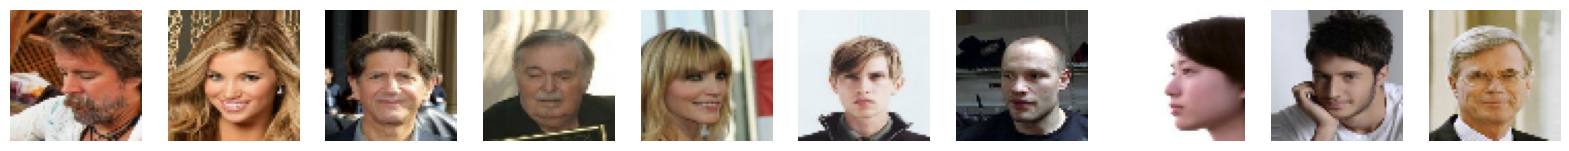

In [15]:
train_sample = sample_batch(train)
display(train_sample)

In [16]:
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers

ebm_input = layers.Input(shape=(64, 64, 3))
x = layers.Conv2D(
    16, kernel_size=5, strides=2, padding="same", activation="swish",
    kernel_regularizer=regularizers.l2(0.01)
)(ebm_input)
x = layers.Conv2D(
    32, kernel_size=3, strides=2, padding="same", activation="swish",
    kernel_regularizer=regularizers.l2(0.01)
)(x)
x = layers.Conv2D(
    64, kernel_size=3, strides=2, padding="same", activation="swish",
    kernel_regularizer=regularizers.l2(0.01)
)(x)
x = layers.Conv2D(
    128, kernel_size=3, strides=2, padding="same", activation="swish",
    kernel_regularizer=regularizers.l2(0.01)
)(x)
x = layers.Flatten()(x)
x = layers.Dense(
    256, activation="swish",
    kernel_regularizer=regularizers.l2(0.01)
)(x)
x = layers.Dropout(0.5)(x)
ebm_output = layers.Dense(1)(x)

model = models.Model(ebm_input, ebm_output)
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 conv2d_8 (Conv2D)           (None, 32, 32, 16)        1216      
                                                                 
 conv2d_9 (Conv2D)           (None, 16, 16, 32)        4640      
                                                                 
 conv2d_10 (Conv2D)          (None, 8, 8, 64)          18496     
                                                                 
 conv2d_11 (Conv2D)          (None, 4, 4, 128)         73856     
                                                                 
 flatten_2 (Flatten)         (None, 2048)              0         
                                                                 
 dense_4 (Dense)             (None, 256)               5245

In [17]:
def generate_samples(
    model, inp_imgs, steps, step_size, noise, return_img_per_step=False
):
    imgs_per_step = []
    for _ in range(steps):
        inp_imgs += tf.random.normal(inp_imgs.shape, mean=0, stddev=noise)
        inp_imgs = tf.clip_by_value(inp_imgs, -1.0, 1.0)
        with tf.GradientTape() as tape:
            tape.watch(inp_imgs)
            out_score = model(inp_imgs)
        grads = tape.gradient(out_score, inp_imgs)
        grads = tf.clip_by_value(grads, -0.03, 0.03)
        inp_imgs += step_size * grads
        inp_imgs = tf.clip_by_value(inp_imgs, -1.0, 1.0)
        if return_img_per_step:
            imgs_per_step.append(inp_imgs)
    if return_img_per_step:
        return tf.stack(imgs_per_step, axis=0)
    else:
        return inp_imgs

In [18]:
import random

class Buffer:
    def __init__(self, model):
        super().__init__()
        self.model = model
        self.examples = [
            tf.random.uniform(shape=(1, 64, 64, 3)) * 2
            - 1
            for _ in range(128)
        ]

    def sample_new_exmps(self, steps, step_size, noise):
        n_new = np.random.binomial(128, 0.05)
        rand_imgs = (
            tf.random.uniform((n_new, 64, 64, 3)) * 2 - 1
        )
        old_imgs = tf.concat(
            random.choices(self.examples, k=128 - n_new), axis=0
        )
        inp_imgs = tf.concat([rand_imgs, old_imgs], axis=0)
        inp_imgs = generate_samples(
            self.model, inp_imgs, steps=steps, step_size=step_size, noise=noise
        )
        self.examples = tf.split(inp_imgs, 128, axis=0) + self.examples
        self.examples = self.examples[:8192]
        return inp_imgs

In [30]:
class EBM(models.Model):
    def __init__(self):
        super(EBM, self).__init__()
        self.model = model
        self.buffer = Buffer(self.model)
        self.alpha = 0.1
        self.loss_metric = metrics.Mean(name="loss")
        self.reg_loss_metric = metrics.Mean(name="reg")
        self.cdiv_loss_metric = metrics.Mean(name="cdiv")
        self.real_out_metric = metrics.Mean(name="real")
        self.fake_out_metric = metrics.Mean(name="fake")

    @property
    def metrics(self):
        return [
            self.loss_metric,
            self.reg_loss_metric,
            self.cdiv_loss_metric,
            self.real_out_metric,
            self.fake_out_metric,
        ]

    def train_step(self, real_imgs):
        real_imgs += tf.random.normal(
            shape=tf.shape(real_imgs), mean=0, stddev=0.005
        )
        real_imgs = tf.clip_by_value(real_imgs, -1.0, 1.0)
        fake_imgs = self.buffer.sample_new_exmps(
            steps=60, step_size=10, noise=0.005
        )
        inp_imgs = tf.concat([real_imgs, fake_imgs], axis=0)
        with tf.GradientTape() as training_tape:
            real_out, fake_out = tf.split(self.model(inp_imgs), 2, axis=0)
            cdiv_loss = tf.reduce_mean(fake_out, axis=0) - tf.reduce_mean(
                real_out, axis=0
            )
            reg_loss = self.alpha * tf.reduce_mean(
                real_out**2 + fake_out**2, axis=0
            )
            loss = cdiv_loss + reg_loss
        grads = training_tape.gradient(loss, self.model.trainable_variables)
        self.optimizer.apply_gradients(
            zip(grads, self.model.trainable_variables)
        )
        self.loss_metric.update_state(loss)
        self.reg_loss_metric.update_state(reg_loss)
        self.cdiv_loss_metric.update_state(cdiv_loss)
        self.real_out_metric.update_state(tf.reduce_mean(real_out, axis=0))
        self.fake_out_metric.update_state(tf.reduce_mean(fake_out, axis=0))
        return {m.name: m.result() for m in self.metrics}

    def test_step(self, real_imgs):
        batch_size = real_imgs.shape[0]
        fake_imgs = (
            tf.random.uniform((batch_size, 64, 64, 3))
            * 2
            - 1
        )
        inp_imgs = tf.concat([real_imgs, fake_imgs], axis=0)
        real_out, fake_out = tf.split(self.model(inp_imgs), 2, axis=0)
        cdiv = tf.reduce_mean(fake_out, axis=0) - tf.reduce_mean(
            real_out, axis=0
        )
        self.cdiv_loss_metric.update_state(cdiv)
        self.real_out_metric.update_state(tf.reduce_mean(real_out, axis=0))
        self.fake_out_metric.update_state(tf.reduce_mean(fake_out, axis=0))
        return {m.name: m.result() for m in self.metrics[2:]}

In [31]:
ebm = EBM()

In [32]:
ebm.compile(
    optimizer=optimizers.Adam(learning_rate=0.0005), run_eagerly=True
)

In [22]:
!mkdir output/

In [23]:
tensorboard_callback = callbacks.TensorBoard(log_dir="./logs")


class ImageGenerator(callbacks.Callback):
    def __init__(self, num_img):
        self.num_img = num_img

    def on_epoch_end(self, epoch, logs=None):
        start_imgs = (
            np.random.uniform(
                size=(self.num_img, 64, 64, 3)
            )
            * 2
            - 1
        )
        generated_images = generate_samples(
            ebm.model,
            start_imgs,
            steps=1000,
            step_size=10,
            noise=0.005,
            return_img_per_step=False,
        )
        generated_images = generated_images.numpy()
        display(
            generated_images,
            save_to="./output/generated_img_%03d.png" % (epoch),
        )

        example_images = tf.concat(
            random.choices(ebm.buffer.examples, k=10), axis=0
        )
        example_images = example_images.numpy()
        display(
            example_images, save_to="./output/example_img_%03d.png" % (epoch)
        )


image_generator_callback = ImageGenerator(num_img=10)

In [ ]:
ebm.fit(
    train,
    shuffle=True,
    epochs=15,
    callbacks=[
        tensorboard_callback,
        image_generator_callback,
    ],
)

GPU limited exceeded therefore only ran for 1 epoch

In [34]:
start_imgs = (
    np.random.uniform(size=(10, 64, 64, 3)) * 2 - 1
)

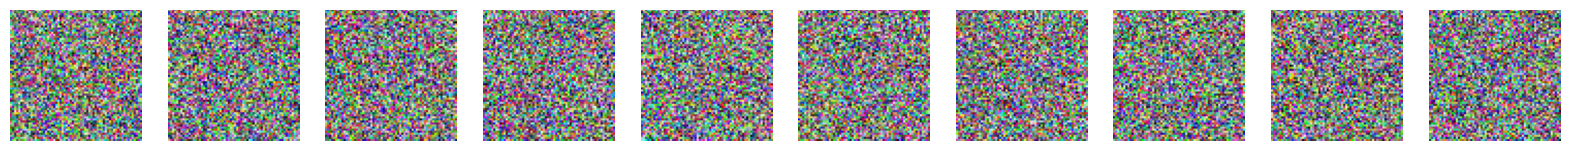

In [35]:
display(start_imgs)

In [36]:
gen_img = generate_samples(
    ebm.model,
    start_imgs,
    steps=10000,
    step_size=10,
    noise=0.005,
    return_img_per_step=True,
)

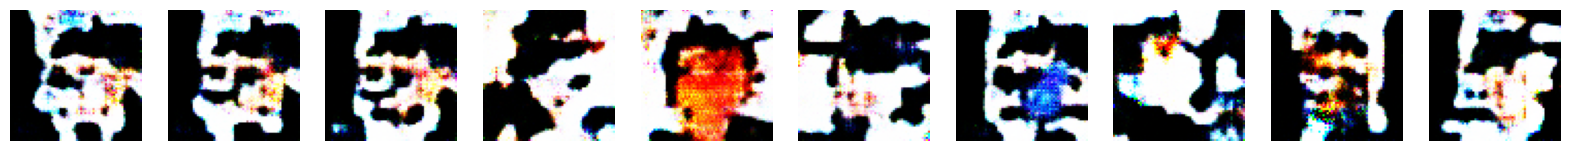

In [37]:
display(gen_img[-1].numpy())

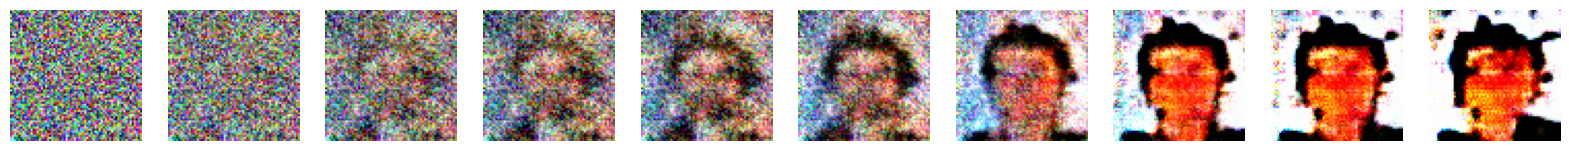

In [38]:
imgs = []
for i in [0, 10, 30, 50, 100, 300, 1000, 3000, 5000, 9999]:
    imgs.append(gen_img[i].numpy()[4])

display(np.array(imgs))

In [39]:
start_imgs = (
    np.random.uniform(size=(10, 64, 64, 3)) * 2 - 1
)

In [40]:
gen_img = generate_samples(
    ebm.model,
    start_imgs,
    steps=3000,
    step_size=10,
    noise=0.005,
    return_img_per_step=True,
)

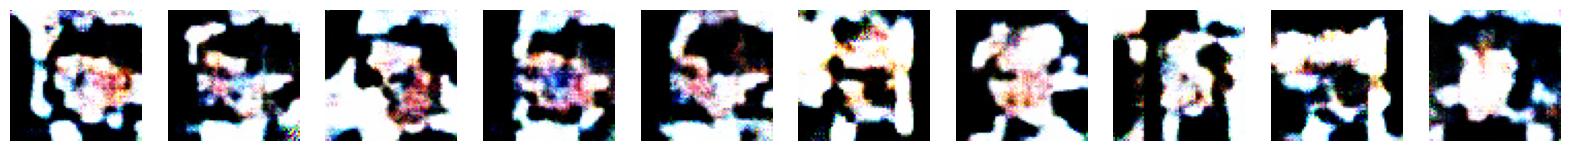

In [41]:
display(gen_img[-1].numpy())

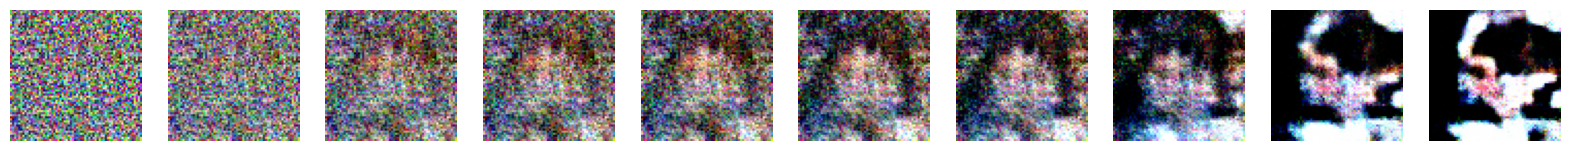

In [42]:
imgs = []
for i in [0, 10, 30, 50, 100, 300, 500, 1000, 2000, 2999]:
    imgs.append(gen_img[i].numpy()[4])

display(np.array(imgs))